# Tabular synthetic data 
### A generation and evaluation example with **Clearbox Synthetic Kit**

This notebook walks you through the tabular synthetic data generation and evaluation process with **Clearbox Synthetic Kit**.

You can run this notebook on Google Colab or on your local machine.<br> 
In the second case, we highly recommend to create a dedicated virtual environment.

To run this notebook, make sure you change the runtime as <br>
*Runtime->Change Runtime Type* and set Hardware Accelerator to "GPU"

In [ ]:
# Install the library and its dependencies

%pip install clearbox-synthetic-kit

In [ ]:
# Import necessary dependencies
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from clearbox_synthetic import (
        Dataset, 
        Preprocessor, 
        TabularEngine, 
        LabeledSynthesizer, 
        PrivacyScore
    )


## 0. Data import and preparation

In [ ]:
# Load the example datasets from GitHub

file_path = "https://raw.githubusercontent.com/Clearbox-AI/clearbox-synthetic-kit/main/tests/resources/uci_adult_dataset"

train_dataset = Dataset.from_csv(
        os.path.join(file_path, "dataset.csv"),
        target_column="income",
        regression=False
    )

validation_dataset = Dataset.from_csv(
        os.path.join(file_path, "validation_dataset.csv"),
        column_types=train_dataset.column_types,
        target_column=train_dataset.target_column,
        regression=train_dataset.regression
    )

### Data pre-processing
Datasets are pre-processd with the **Preprocessor** class, which prepares data for the subsequent steps.

In [ ]:
# Preprocessor initialization
preprocessor = Preprocessor(train_dataset) 

# Preprocessing training dataset 
X_train_raw = train_dataset.get_x() # Get all columns of the training dataset except the target column (y)
X_train = preprocessor.transform(X_train_raw)

In [ ]:
# Preprocessing validation dataset

X_val_raw = validation_dataset.get_x() # Get all columns of the validation dataset except the target column (y)
X_val = preprocessor.transform(X_val_raw)

In [6]:
# Normalize the target column (y) of the training dataset if train_dataset.regression is True, otherwise perform one-hot encoding on that column

if train_dataset.regression:
    Y = train_dataset.get_normalized_y()
else:
    Y = train_dataset.get_one_hot_encoded_y()

## 1. Synhetic Data Generation

In [ ]:
# Initialize the tabular synthetic data generator

engine = TabularEngine(
    layers_size=[50],
    x_shape=X_train[0].shape,
    y_shape=Y[0].shape,
    numerical_feature_sizes=preprocessor.get_features_sizes()[0],
    categorical_feature_sizes=preprocessor.get_features_sizes()[1],
)

# Start the training of the tabular synthetic data generator

engine.fit(X_train, y_train_ds=Y, epochs=5, learning_rate=0.001)

In [10]:
# Initilaize the Synthetsizer for data generation

synthesizer = LabeledSynthesizer(train_dataset, engine)

In [11]:
# Generate the syntehtic dataset from the Synthesizer and save it to a .csv file

pd_synthetic_dataset = synthesizer.generate(has_header=True)

pd_synthetic_dataset.to_csv("synthetic_dataset.csv", index=False)

In [12]:
# Load the synethetic dataset

synthetic_dataset = Dataset.from_csv(
        "synthetic_dataset.csv",
        column_types=train_dataset.column_types,  
        target_column=train_dataset.target_column, 
        regression=train_dataset.regression
    )

## 2. Synththic Data Evaluation

## 2.1 Privacy evaluation
The library features the PrivacyScore class, which computes an overall privacy score of the synthetic dataset including metrics like **Distances to Closest Record** and vulnerability to **Membership Inference Attack simulation**

In [ ]:
privacy_metrics = PrivacyScore(
        train_dataset, 
        synthetic_dataset, 
        validation_dataset, 
        preprocessor, 
        parallel=True
    ).get()

In [19]:
training_metrics            = privacy_metrics['training_metrics']
synthetic_metrics           = privacy_metrics['synthetic_metrics']
synthetic_training_metrics  = privacy_metrics['synthetic_training_metrics']
synthetic_holdout_metrics   = privacy_metrics['synthetic_holdout_metrics']
membership_inference_test   = privacy_metrics['membership_inference_test']

### 2.1.1 Distances to Closest Record (DCR)
0. The **distance matrix** is calculated between two dataframes that contain mixed data types, including both numerical and categorical variables. This computation leverages a modified version of Gower's distance.

1. Following this, the **DCR** (**Distance to Closest Record**) **vector** is then derived by determining the shortest distance between each record in the synthetic dataset and all records in the original dataset.<br>
For each synthetic record, the smallest distance among all pairwise distances to records in the original dataset is identified.<br> 
This step effectively quantifies how closely each synthetic record resembles the original data, with smaller values indicating greater similarity.

2. The **distribution of DCR** values is then analyzed to assess the level of anonymization and safety of the synthetic dataset. Specifically:

- *Overlap of DCR Distributions*:
    
    If the distribution of DCR values between the synthetic and training dataset closely overlaps with the distribution of DCR values between the synthetic and holdout dataset, it indicates that the synthetic data does not reveal whether a record from the original dataset was used to train the synthetic data generator. In this case, the synthetic dataset can be considered sufficiently anonymized and safe from reidentification attacks, as there is no evidence that the generator is overfitting to specific records in the training data.

- *Lack of Overlap in DCR Distributions*:

    Conversely, if the DCR distribution between the synthetic and training dataset differs significantly from that of the synthetic and holdout dataset, it raises concerns about the privacy and anonymization of the synthetic dataset.
    
    Specifically, if the DCR distribution for the synthetic and training dataset contains a greater proportion of smaller distances (indicating higher similarity) compared to the holdout dataset, this suggests that many synthetic records are too similar to the training records.<br>
    This lack of diversity increases the risk of reidentification, even if the synthetic dataset has undergone anonymization procedures.<br>
    Such a scenario implies that the synthetic data generator has overfit to the training dataset, compromising its ability to generate sufficiently diverse and independent synthetic records.

3. Finally, the **share** of synthetic rows closer to the training dataset than to the validation dataset is computed as:

$$ DCR\_share = \frac{number\space of\space DCR\_synth\_train \space smaller\space than\space DCR\_synth\_holdout}{total \space number \space of \space DCR\_synth\_train \space rows}   * 100$$

If the percentage is close to or below 50%, it provides empirical evidence that the training and validation data are interchangeable with respect to the synthetic data. This indicates that the synthetic data does not disproportionately resemble the training dataset.<br> 
In such a case, it would not be possible to infer whether a specific individual was or was not included in the training dataset based on the synthetic data alone.<br>
Conversely, if the DCR share exceeds 50%, it suggests that the synthetic dataset contains a significant number of records that are easily reidentifiable. This is a strong indicator that the synthetic data overfits the training data, potentially compromising its anonymization and exposing individuals to reidentification risks.

            Duplicates stats
----------------------------------------
                    Training Synthetic
Duplicates              1933      1038
Duplicates %         11.87 %    6.38 %
Unique duplicates       1136       580
Unique duplicates %   6.98 %    3.56 %


Synthetic-Training clones: 1595 (9.80 %)


                   DCR stats
----------------------------------------------
        Synthetic-Training   Synthetic-Holdout
mean               0.051470           0.056892
min                0.000000           0.000000
25%                0.004215           0.007064
median             0.033429           0.076923
75%                0.082192           0.085331
max                0.308746           0.314778


Synthetic-Training vs. Synthetic-Holdout Test (DCR share): 47.69 %


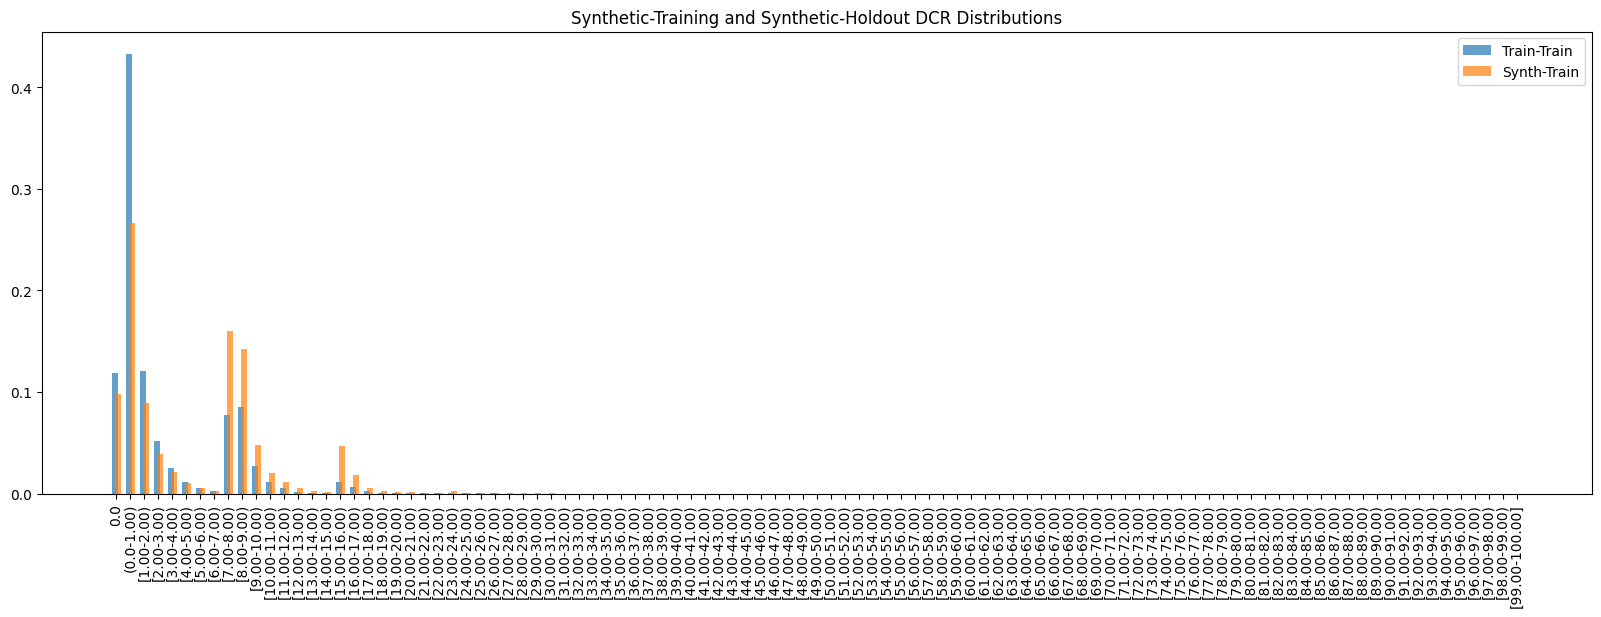

In [78]:
def display_DCR_results(training_metrics, synthetic_metrics, synthetic_training_metrics, synthetic_holdout_metrics):
    # Display useful DCR stats
    print("            Duplicates stats")
    print("----------------------------------------")
    print(pd.DataFrame({'Training':[f"{training_metrics['training_duplicates']}", f"{round(training_metrics['training_duplicates_percentage'],2)} %", f"{training_metrics['training_unique_duplicates']}", f"{round(training_metrics['training_unique_duplicates_percentage'],2)} %"], 
                        'Synthetic':[f"{synthetic_metrics['synthetic_duplicates']}", f"{round(synthetic_metrics['synthetic_duplicates_percentage'],2)} %", f"{synthetic_metrics['synthetic_unique_duplicates']}", f"{round(synthetic_metrics['synthetic_unique_duplicates_percentage'],2)} %"]}, 
                        index=["Duplicates", "Duplicates %", "Unique duplicates", "Unique duplicates %"]))


    print(f"\n\nSynthetic-Training clones: {synthetic_training_metrics['synth_train_clones']} ({synthetic_training_metrics['synth_train_clones_percentage']:.2f} %)")

    print("\n\n                   DCR stats")
    print("----------------------------------------------")
    print(pd.DataFrame({'Synthetic-Training ': synthetic_training_metrics['dcr_synth_train_stats'], 'Synthetic-Holdout': synthetic_holdout_metrics['dcr_synth_holdout_stats']}))

    print("\n\nSynthetic-Training vs. Synthetic-Holdout Test (DCR share): {:.2f} %".format(synthetic_holdout_metrics['synth_holdout_test']))

def plot_DCR_results(training_metrics, synthetic_training_metrics):
    # Plot DCR synth-train and synth-holdout histograms
    labels = training_metrics['dcr_train_train_hist']['bins']
    train_train_counts = training_metrics['dcr_train_train_hist']['counts'] / np.sum(training_metrics['dcr_train_train_hist']['counts'])
    synth_train_counts = synthetic_training_metrics['dcr_synth_train_hist']['counts'] / np.sum(synthetic_training_metrics['dcr_synth_train_hist']['counts'])
    X_axis = np.arange(len(labels))
    plt.figure(figsize=(20,6))
    plt.xticks(X_axis, labels, rotation='vertical')
    plt.bar(X_axis-0.1, train_train_counts, 0.4, label = 'Train-Train', alpha=0.7)
    plt.bar(X_axis+0.1, synth_train_counts, 0.4, label = 'Synth-Train', alpha=0.7)
    plt.legend()
    plt.title("Synthetic-Training and Synthetic-Holdout DCR Distributions")

display_DCR_results(training_metrics, synthetic_metrics, synthetic_training_metrics, synthetic_holdout_metrics)
plot_DCR_results(training_metrics, synthetic_training_metrics)

### 2.1.2 Membership Inference Attack
The **Membership Inference Test** is a critical evaluation used to estimate the risk of revealing membership information in a dataset.<br> 
This test assesses how well an adversary, armed with certain prior knowledge, could infer whether specific records were part of the original training dataset used to generate the synthetic data.

**Why Membership Inference Poses a Privacy Risk**<br>

A malicious attacker who has prior knowledge of one or more records in the original dataset can use the membership inference test to determine if those records were part of the training dataset used to generate the synthetic data.<br> 
This process can compromise the privacy of the original dataset in several ways:

- *Revealing Sensitive Information*:

    If the synthetic dataset retains too much similarity to the original data, the attacker can infer sensitive details about individuals or entities, such as health records, financial transactions, or other private attributes.
- *Increased Risk of Reidentification*:

    The more closely the synthetic data resembles the training data, the higher the risk that an attacker can reidentify individuals within the synthetic dataset, thus violating their privacy.
- *Erosion of Anonymization*:

    The goal of synthetic data is to anonymize original records while maintaining data utility. However, if membership inference is successful, it undermines the very purpose of synthetic data generation by exposing private information.

Synthetic data generation techniques must ensure that records in the synthetic dataset cannot be linked back to the original dataset with high confidence.

**How the Membership Inference Test Works**

1. *Distance to the Closest Record (DCR)*:

    The test calculates the **DCR** (**Distance to the Closest Record**) for each record in the adversary dataset by measuring its distance to all records in the synthetic dataset.<br>
    The DCR quantifies how closely an adversary’s known records resemble records in the synthetic dataset.
2. *Threshold-Based Risk Evaluation*:

    A set of distance thresholds is applied to the DCR values. These thresholds determine whether a record is considered sufficiently "close" to indicate membership in the original dataset.<br>
    For each threshold, the test computes precision scores, which reflect how accurately the synthetic dataset can be linked back to specific records in the adversary dataset.
3. *Privacy Risk Assessment*:

    If many records from the adversary dataset are identified with high precision (low DCR values), this indicates that the synthetic data strongly resembles the original data, increasing the risk of membership inference.<br>
    Conversely, if the precision scores are low across thresholds, it suggests that the synthetic dataset is well-anonymized, reducing the likelihood of successful membership inference.

    The **MI Mean Risk score** is computed as $(precision - 0.5) * 2$.<br>
    MI Risk Score smaller than 0.2 (20%) are considered to be very LOW RISK of disclosure due to membership inference.

In [74]:
print("Membership Inference Test")
print("  Adversary Distance Thresholds: {}".format(membership_inference_test['adversary_distance_thresholds']))
print("  Adversary Precision Score: {}".format(membership_inference_test['adversary_precisions']))
print("  Membership Inference Mean Risk Score: {:.4f}".format(membership_inference_test['membership_inference_mean_risk_score']))

Membership Inference Test
  Adversary Distance Thresholds: [0.013881421647965908, 0.003161222208291292, 0.002107481472194195, 0.0]
  Adversary Precision Score: [0.500615763546798, 0.5294888597640891, 0.5472175379426644, 0.5]
  Membership Inference Mean Risk Score: 0.0387


## 2.2 Utilty evaluation
### 2.2.1 Detection
The detection score is computed to evaluate the 
quality of a synthetic dataset by training a XGBoost classifier 
to distinguish between original and synthetic data.<br>
The lower the model's accuracy, the higher the quality of the synthetic data.

The feature importance for the detection task with XGBoost model is also computed.<br>
If a feature has high importance, it means the synthetic data for that feature differs significantly from the original data.
This can suggest that the synthetic data generator has failed to accurately replicate the distribution of this feature, making it a "weak spot" in the synthetic dataset.

In [ ]:
from clearbox_synthetic import DetectionScore

detection_score = DetectionScore(
        train_dataset, 
        synthetic_dataset, 
        preprocessor
    ).get()

Detection results:
  Accuracy:  0.6974
  ROC AUC:   0.7846
  Score:     0.4308


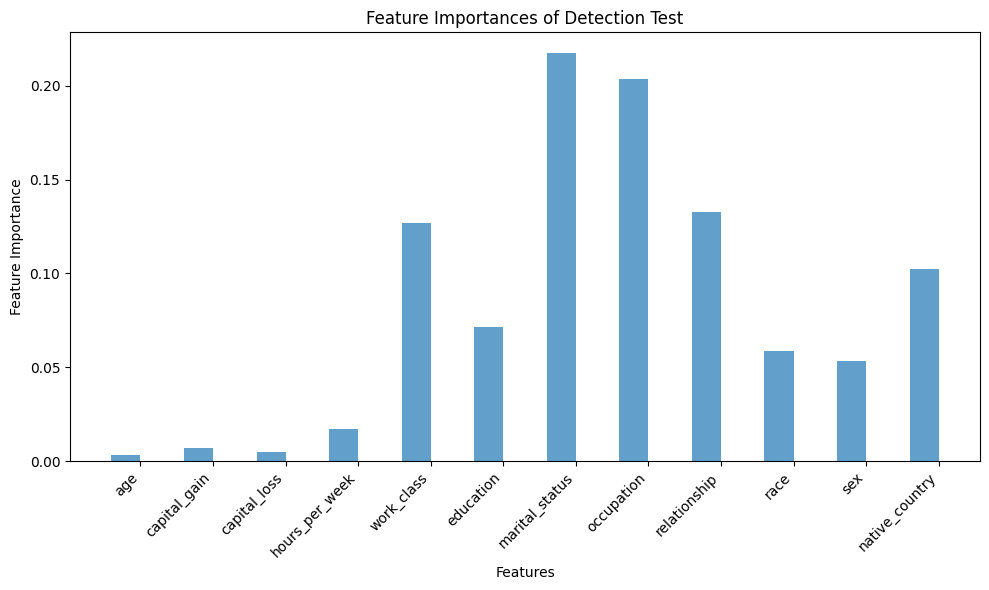

In [76]:
def display_detection_results(detection_score):
    print("Detection results:")
    print("  Accuracy: ", round(detection_score["accuracy"],4))
    print("  ROC AUC:  ", round(detection_score["ROC_AUC"],4))
    print("  Score:    ", round(detection_score["score"],4))

def plot_feature_importance_detection(detection_score):
    importances = detection_score["feature_importances"]    

    features = list(importances.keys())
    values = np.array([importances[f] for f in features])

    x = np.arange(len(features)) 
    width = 0.4 

    plt.figure(figsize=(10, 6))
    plt.bar(x - width / 2, values, width, alpha=0.7)

    plt.xticks(x, features, rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances of Detection Test")

    plt.tight_layout()
    plt.show()

display_detection_results(detection_score)
plot_feature_importance_detection(detection_score)

### 2.2.2 Train on Synthetic, Test on Real (TSTR)
The TSTRScore class cwhich calculates the Train on Synthetic Test on Real (TSTR) score
for a machine learning task (regression or classification) using XGBoost models. 
The class compares the performance of models trained on original and synthetic datasets.

The feature importances are also computed for the TSTR task.
Here is a brief abstract on how to interpret the results of the feature importances:
- High feature importance with poor performance:

    - The synthetic data for this feature is likely not representative of the real data, causing the model to rely on misleading patterns.
    - This is a weakness in the synthetic dataset and should be investigated further.
- High feature importance with good performance:

    - Indicates that the synthetic data for this feature captures the real data's patterns well, making it a strong point of the synthetic dataset.
- Low feature importance:

     - Suggests that the feature is less relevant to the task or that the synthetic data for this feature fails to capture meaningful patterns, making it less useful.

In [141]:
from clearbox_synthetic import TSTRScore

TSTR_score = TSTRScore(
        train_dataset, 
        synthetic_dataset, 
        validation_dataset,
        preprocessor
    ).get()

In [211]:
def display_TSTR(TSTR_score):
    # Extract metrics for training and synthetic into dataframes
    training_metrics = pd.DataFrame(TSTR_score['metrics']['training']).assign(Dataset='Training')
    training_metrics = training_metrics[["Dataset"] + [col for col in training_metrics.columns if col != "Dataset"]]

    synthetic_metrics = pd.DataFrame(TSTR_score['metrics']['synthetic']).assign(Dataset='Synthetic')
    synthetic_metrics = synthetic_metrics[["Dataset"] + [col for col in training_metrics.columns if col != "Dataset"]]

    # Combine both into a single table
    results_table = pd.concat([training_metrics, synthetic_metrics], ignore_index=True)

    # Add accuracy information to the table
    accuracy_table = pd.DataFrame([
        {'Dataset': 'Training', 'Accuracy': TSTR_score['accuracy']['training']},
        {'Dataset': 'Synthetic', 'Accuracy': TSTR_score['accuracy']['synthetic']}
    ])

    print("TSTR task: ", TSTR_score["task"])
    print("TSTR score: ", TSTR_score["score"])

    print("\n",accuracy_table.to_string(index=False))
    print("\n",results_table.to_string(index=False))

display_TSTR(TSTR_score)

TSTR task:  classification
TSTR score:  0.9842

   Dataset  Accuracy
 Training    0.8714
Synthetic    0.8556

   Dataset label  precision  recall  fscore  support
 Training <=50K     0.8978  0.9386  0.9177  12435.0
 Training  >50K     0.7671  0.6544  0.7063   3846.0
Synthetic <=50K     0.8871  0.9292  0.9077  12435.0
Synthetic  >50K     0.7295  0.6178  0.6690   3846.0


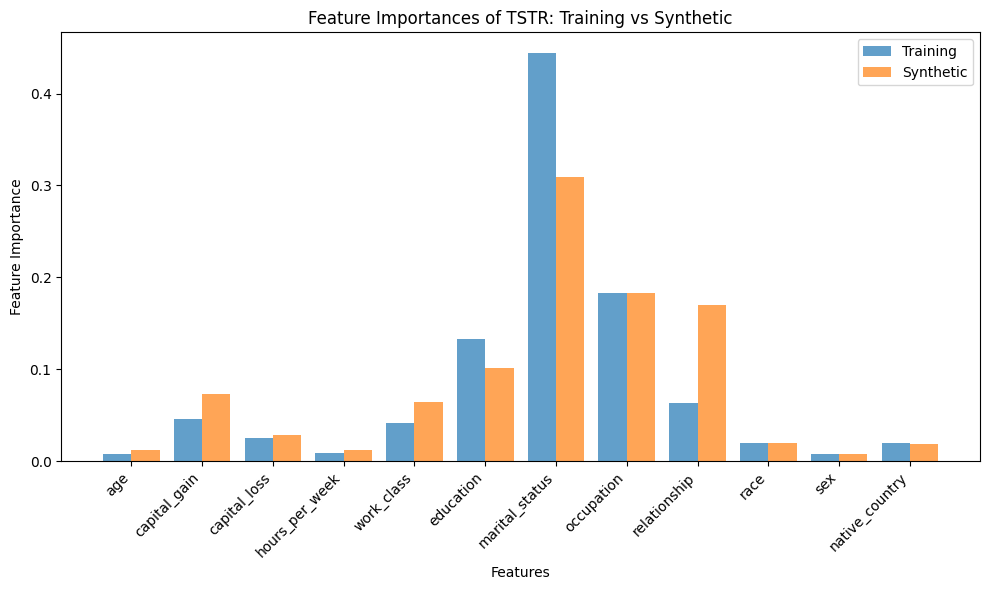

In [ ]:
# Plot Feature Importance for Training and Synthetic dataset
def plot_feature_importance_TSTR(TSTR_score):
    training_importances = TSTR_score["feature_importances"]["training"]
    synthetic_importances = TSTR_score["feature_importances"]["synthetic"]

    features = list(training_importances.keys())
    training_values = np.array([training_importances[f] for f in features])
    synthetic_values = np.array([synthetic_importances[f] for f in features])

    x = np.arange(len(features)) 
    width = 0.4 

    plt.figure(figsize=(10, 6))
    plt.bar(x - width / 2, training_values, width, label="Training", alpha=0.7)
    plt.bar(x + width / 2, synthetic_values, width, label="Synthetic", alpha=0.7)

    plt.xticks(x, features, rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances of TSTR: Training vs Synthetic")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_feature_importance_TSTR(TSTR_score)

### 2.2.3 Mutual Information

The MutualInformation class calculates the mutual information
between features in original and synthetic datasets. The comparison helps assess the 
similarity between the feature relationships in both datasets.

In [ ]:
from clearbox_synthetic import MutualInformation

import plotly.graph_objects as go
import plotly.subplots as sp


mi = MutualInformation(train_dataset, synthetic_dataset).get()

def plot_mutual_info(mi):
    keys = ["original_mutual_information", "synthetic_mutual_information", "diff_correlation_matrix"]

    fig = sp.make_subplots(
        rows=1, 
        cols=3, 
        shared_yaxes=True, 
        subplot_titles=keys
    )

    for i, key in enumerate(keys, start=1):
        matrix = np.array(mi[key])

        # Mask the upper triangle (including the diagonal)
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        lower_triangle_matrix = np.where(mask, np.nan, matrix)

        df = pd.DataFrame(
            np.flip(lower_triangle_matrix,0), 
            columns=mi["features"], 
            index=list(reversed(mi["features"]))
        )

        fig.add_trace(
            go.Heatmap(
                z=df.values,
                x=df.columns,
                y=df.index,
                colorscale="RdBu",  
                zmin=-1,
                zmax=1,
                colorbar=dict(title="Correlation")
            ),
            row=1,
            col=i
        )

    fig.update_layout(
        # title=f"Correlation Matrices - Mutual Information Score: {mi['score']}",
        title={"text": f"Correlation Matrices<br><sub style='font-size: 16px; color: gray;'>Mutual Information Score: {mi['score']}</sub>"},
        height=500,
        width=1200,
    )

    fig.show()

# Plot the correlation matrices
plot_mutual_info(mi)

### 2.2.4 Statistical properties of features
The FeaturesComparison class compares the statistical
properties of features between an original training dataset and a synthetic dataset. It
provides detailed statistics for numerical, categorical, and datetime features.

In [196]:
from clearbox_synthetic import FeaturesComparison

fc = FeaturesComparison(
        train_dataset, 
        synthetic_dataset, 
        preprocessor
    ).get()

In [207]:
# Example of statistical properties comparison between the training and the synthetic dataset for variable "age"
from typing import List

def display_feature_comparison(fc, features: List):
    for feature in features:
        if "values" in fc[feature].keys():
            fc[feature].pop("values")
        print("Feature: ", feature)
        print("-----------------------")
        print(pd.DataFrame(fc[feature]))
        print("\n===================================================================\n")

features = ["age", "education", "sex"]
display_feature_comparison(fc, features)

Feature:  age
-----------------------
             type  na_values  unique_values     mean      std   min  \
training   number        0.0           73.0  38.5816  13.6404  17.0   
synthetic  number        0.0           73.0  38.6383  13.6553  17.0   

           first_quartile  second_quartile  third_quartile   max  
training             28.0             37.0            48.0  90.0  
synthetic            28.0             37.0            48.0  90.0  


Feature:  education
-----------------------
                  type  na_values  unique_values
training   categorical        0.0           16.0
synthetic  categorical        0.0            9.0


Feature:  sex
-----------------------
                  type  na_values  unique_values
training   categorical        0.0            2.0
synthetic  categorical        0.0            2.0




### 2.2.5 Query test
The QueryPower class assesses the quality of a synthetic dataset
by running queries that compare it to the original dataset. The closer the query results
are between both datasets, the higher the quality of the synthetic data.

In [174]:
from clearbox_synthetic import QueryPower

qp = QueryPower(train_dataset, synthetic_dataset, preprocessor).get()

print(f"Query Power score: {qp['score']}")
qp_df = pd.DataFrame(qp["queries"])
qp_df.rename(columns={"text": "Query"}, inplace=True)
qp_df

Query Power score: 0.9867


,Query,original_df,synthetic_df
0,`capital_gain` >= 0.0 and `native_country` != ...,31918,31633
1,`work_class` != 'Self-emp-inc' and `marital_st...,30481,30086
2,`relationship` != 'Unmarried' and `education` ...,1198,1086
3,`capital_loss` <= 0.0 and `sex` == 'Female',10402,10667
4,`occupation` != 'Prof-specialty' and `race` !=...,27568,26461


### 2.2.6 Reconstruction error
The ReconstructionError class calculates the reconstruction
error for both original and synthetic datasets using a specified TabularEngine.
The reconstruction error histograms are generated to compare the quality of synthetic data.

In [ ]:
from clearbox_synthetic import ReconstructionError

reconstruction_error_hist = ReconstructionError(train_dataset, synthetic_dataset, engine, preprocessor).get()

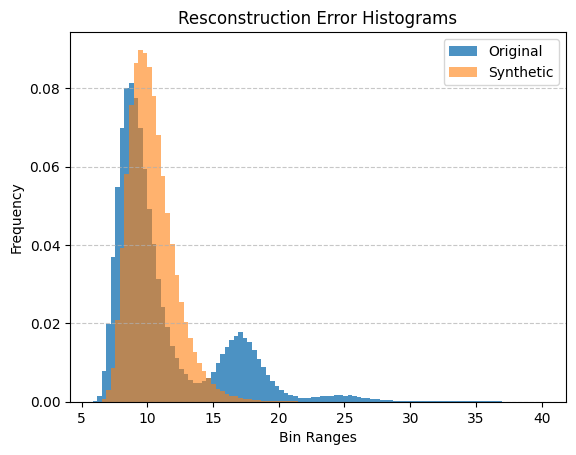

In [175]:
# Plot Reconstruction Error Histogram
def plot_reconstruction_error(reconstruction_error_hist):
    bin_edges      = reconstruction_error_hist["bin_edges"]
    bin_widths     = np.diff(bin_edges)
    original_hist  = reconstruction_error_hist["original_hist"]  
    synthetic_hist = reconstruction_error_hist["synthetic_hist"]

    original_relative_hist  = original_hist  / np.sum(original_hist)  # Normalized frequencies
    synthetic_relative_hist = synthetic_hist / np.sum(synthetic_hist) # Normalized frequencies

    plt.bar(bin_edges[:-1], original_relative_hist[:-1],  label='Original',  width=bin_widths, align='edge', alpha=0.8)
    plt.bar(bin_edges[:-1], synthetic_relative_hist[:-1], label='Synthetic', width=bin_widths, align='edge', alpha=0.6)

    plt.xlabel('Bin Ranges')
    plt.ylabel('Frequency')
    plt.title('Resconstruction Error Histograms')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_reconstruction_error(reconstruction_error_hist)